<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta
import os
import re

from collections import defaultdict
from functools import reduce 

import prophet as pr

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'groceries.csv',
 'scanner_data.csv',
 'online_retail.xlsx',
 '1_orders_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'mall_customers.csv',
 'online_retail_II.xlsx',
 'bz_data_analyis.csv',
 'test.csv',
 'sample-sales-data.csv',
 'sales.csv',
 '1_customers_dataset.csv',
 'sales_data_with_stores.csv',
 'match_result_test.csv',
 'sales_vs_discount.csv',
 '1_order_payments_dataset.csv',
 'mock_sales_data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sample_data']

In [9]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.columns = ['_'.join(re.split('(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower() for a in df.columns]
df['invoice_date'] = pd.to_datetime(df['invoice_date'], infer_datetime_format=True)
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
df = df[(~df.invoice_no.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.unit_price
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country,date,month,rev
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,20.34


In [22]:
cnt = df.groupby(['customerid', 'date'])['rev'].agg(['sum','count']).reset_index().rename(columns = {'customerid':'id'})
cnt.head()

,id,date,sum,count
0,12346.0,2011-01-18,77183.60,1
1,12747.0,2010-12-05,358.56,7
2,12747.0,2010-12-13,347.71,8
3,12747.0,2011-01-20,303.04,5
4,12747.0,2011-03-01,310.78,12


In [23]:
info_m = pd.pivot_table(cnt, index = 'id', columns = 'date', values= 'sum').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'date', value_name = 'money').sort_values(['id', 'date'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(14)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,12346.0,0.00
1,12747.0,438.50
2,12748.0,3726.12
3,12749.0,763.06
4,12820.0,210.35


In [24]:
info_f = pd.pivot_table(cnt, index = 'id', columns = 'date', values= 'count').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'date', value_name = 'freq').sort_values(['id', 'date'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(14)
info_f = info_f.groupby(['id'])['freq'].sum().reset_index()
info_f.head()

,id,freq
0,12346.0,0.0
1,12747.0,7.0
2,12748.0,777.0
3,12749.0,39.0
4,12820.0,12.0


In [27]:
max_date = cnt['date'].max()
max_date

Timestamp('2011-12-09 00:00:00')

In [31]:
info_r = cnt.groupby(['id']).agg({'date' : lambda x : max_date - x.max()}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r.head()

,id,recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


In [35]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info = info.assign(r = pd.qcut(info['recency'], 5, list('12345')),
                   f = pd.qcut(info['freq'].rank(method='first'), 5, list('54321')),
                   m = pd.qcut(info['money'].rank(method='first'), 5, list('54321'))
                   )
info['rf'] = info['r'].astype(str) + info['f'].astype(str)
info.head()

,id,recency,freq,money,r,f,m,rf
0,12346.0,325,0.0,0.00,5,5,5,55
1,12747.0,2,7.0,438.50,1,1,1,11
2,12748.0,0,777.0,3726.12,1,1,1,11
3,12749.0,3,39.0,763.06,1,1,1,11
4,12820.0,3,12.0,210.35,1,1,1,11


In [37]:
cnt2 = info[['r','f']].value_counts().reset_index()
cnt2.columns = ['r', 'f', 'cnt']
cnt2.head()

,r,f,cnt
0,1,1,711
1,3,3,225
2,4,5,217
3,3,4,207
4,5,4,205


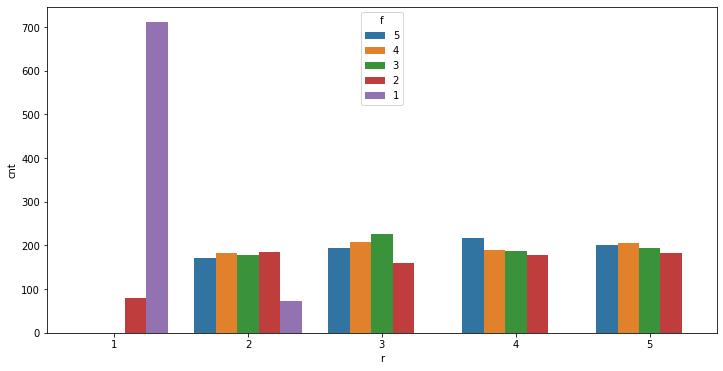

In [39]:
plt.figure(figsize = [12, 6])
sns.barplot(data = cnt2, x = 'r', y = 'cnt', hue = 'f')

# Iterators

In [40]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [42]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}